First, we must construct our environment...

In [1]:
import numpy as np
import matplotlib
from rl_glue import RLGlue
from Agent import BaseAgent 
from Environment import BaseEnvironment  
from manager import Manager
import torch

import jdc

In [2]:
# Like shown previously, lets declare first, then implement
class CaptureGoEnvironment(BaseEnvironment):
    def env_init(self, env_info={}):
        return NotImplementedError
    
    def env_start(self):
        raise NotImplementedError

    def env_step(self, action):
        raise NotImplementedError

    def env_cleanup(self):
        raise NotImplementedError
    
    # Gets the value of a position on the game-board
    def board_index(self, x, y):
        raise NotImplementedError
    
    def inBounds(self, x, y):
        raise NotImplementedError
    
    def get_liberties(self, x, y):
        raise NotImplementedError
    
    def get_liberties_helper(self, x, y, group_color, visted_coords):
        raise NotImplementedError
    
    def did_group_captured(self, x, y):
        raise NotImplementedError
    
    # Helper: Print the board
    def print_go_board(self):
        raise NotImplementedError
    
    # Helper: Get the size of the board (how many tiles)
    def go_board_size(self):
        raise NotImplementedError
    
    # Helper: get the board (state)
    def get_board(self):
        raise NotImplementedError
    
    # Helper: get the board state in the form of a tensor
    def get_board_tensor(self): 
        raise NotImplementedError
    
    # Turns an action state into an x y pair
    # This is a litttllleee redundant since we do a bunch of transforms, but it is easier for me to read
    def action_int_to_xy(self, action_int):
        raise NotImplementedError

In [3]:
%%add_to CaptureGoEnvironment

# Create the environment, declare its variables, etc
def env_init(self, env_info={}):

    # Declare our variables
    reward = None

    # The board is an array of height x width
    # If (x,y) on the board is 0, no stone
    #   if its 1, then a white stone is there
    #   if its -1, then a black stone is there
    self.board = None
    
    termination = None

    # Which player's turn is it?
    # 0 = white's turn
    # 1 = black's turn
    self.turn = None
    # Which player's turn was it last round?
    self.last_turn = None

    # Who won?
    # 0 = nobody yet
    # 1 = white
    # -1 = black
    self.who_won = None

    self.reward_board_termination = (reward, self.board, termination)

    # Set the default board height and width
    self.board_height = env_info.get("board_height", 5) 
    self.board_width = env_info.get("board_width", 5)
    # Set the default reward per step
    self.reward_per_step = env_info.get("reward_per_step", -1)
    # Set the default winning reward and losing reward
    self.winning_reward = env_info.get("winning_reward", 100)
    self.losing_reward = env_info.get("losing_reward", -100)
    # How much we are punished for making an invalid move
    self.invalid_reward = env_info.get("invalid_reward", -5)

In [4]:
%%add_to CaptureGoEnvironment

# Initialize the environment, set its variables, etc
# Called before an agent does anything
# Returns the initialized (full of zeros) board
def env_start(self):

    # Actually initalize
    reward = 0
    # Initialize the board, an array of 0 ints
    self.board = np.zeros(self.board_height * self.board_width, dtype=np.int8)
    termination = False
    
    self.reward_board_termination = (reward, self.board, termination)

    # We start as white's turn
    self.turn = 0
    # The last turn is white's turn, though this will change
    self.last_turn = 0
    # Nobody won yet
    self.who_won = 0

    return self.reward_board_termination[1]

In [5]:
%%add_to CaptureGoEnvironment

# Helper: Print the board
def print_go_board(self):
    x = 0
    y = 0
    
    for x in range(self.board_width):
        for y in range(self.board_height):
            pos = self.board[self.board_index(x, y)]

            stone = "."
            if pos == 1:
                stone = "w"
            if pos == -1:
                stone = "b"

            print(stone, end="")

        print("") # print a newline

# Helper: Get the size of the go board
def go_board_size(self):
    return len(self.board)

# Helper: Get the board (state)
def get_board(self):
    return self.board

# Helper: get the board state in the form of a tensor, also transforms into a float32 since thats what nn.linear expects
#   maybe in the future make it so the nn.Linear takes int8, but for now this should work
def get_board_tensor(self):
    return torch.from_numpy(self.board).to(torch.float32)

# Turns an action state into an x y pair
# This is a litttllleee redundant since we do a bunch of transforms, but it is easier for me to read
def action_int_to_xy(self, action_int):
    y = action_int // self.board_height
    x = action_int % self.board_width

    return x, y


In [6]:
# Testing
testenv = env = CaptureGoEnvironment()
testenv.env_init({"board_height" : 5, "board_width" : 5 })
testenv.env_start()

print(env.action_int_to_xy(7))

(2, 1)


In [7]:
%%add_to CaptureGoEnvironment
## Gets the index of a position on the game-board, given an x y coordinate
#   Returns the index where that position on the board is found
#   top right is x = 0 y = 0  

#   On the actual board array:
#       0 means that position is empty
#       1 means there is a white stone
#       -1 means there is a black stone
def board_index(self, x, y):
    return (self.board_width * y) + x

In [8]:
# Testing
env = CaptureGoEnvironment()
env.env_init({"board_height" : 5, "board_width" : 5 })
print(env.env_start())
print(env.board_index(3, 2))


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
13


In [9]:
%%add_to CaptureGoEnvironment

# Returns true if the coordinate is in the board's bounds, false otherwise
def inBounds(self, x, y):
    if ((x < 0) or (y < 0)):
        return False

    if ((x >= self.board_width) or (y >= self.board_height)):
        return False

    return True

# Recursively get the liberties of a group of stones
#   returns the amount of liberties a group has, and all the coordinates we have visited
#   if group_color == 1, then we are looking for a white group
#   if group_color == -1, then we are looking for a black group
# visited_coords is a list of all coordinates we have visted, so we dont enter into an endless loop
def get_liberties_helper(self, x, y, group_color, visited_coords):
    if (x, y) in visited_coords:
        return 0, visited_coords
    visited_coords.append((x, y))

    # Check our bounds
    if not self.inBounds(x, y):
        return 0, visited_coords

    # Check what stone (or lack thereof) is on this position
    if self.board[self.board_index(x, y)] == 0:
        # liberty!
        return 1, visited_coords
    if self.board[self.board_index(x, y)] != group_color:
        # Blocked liberty
        return 0, visited_coords
    # otherwise this is part of the group, check the neighbors
    liberties = 0
    up, visited_coords = self.get_liberties_helper(x, y + 1, group_color, visited_coords)
    down, visited_coords = self.get_liberties_helper(x, y - 1, group_color, visited_coords)
    right, visited_coords = self.get_liberties_helper(x + 1, y, group_color, visited_coords)
    left, visited_coords = self.get_liberties_helper(x - 1, y, group_color, visited_coords)

    liberties = up + down + left + right
    return liberties, visited_coords

# Get the liberties of a group, starting at x, y
def get_liberties(self, x, y):
    # Set the group_color to be whatever color we started at
    liberties = 0
    coords = []
    liberties, coords = self.get_liberties_helper(x, y, self.board[self.board_index(x, y)], visited_coords=[])
    return liberties


# Returns if any group got captured, given the most recent move
#   returns 0 if no groups got captured
#   returns 1 if a white group got captured
#   returns -1 if a black group got captured
#
#   Parameters
#   x, y : The most recent move
def did_group_captured(self, x, y):
    # The (x, y) offsets we will check
    check_offsets_list = [
        [0, 0], 
        [0, 1], 
        [0, -1], 
        [1, 0], 
        [-1, 0]]

    for offset in check_offsets_list:
        this_x = x + offset[0]
        this_y = y + offset[1]

        if not self.inBounds(this_x, this_y):
            # This offset is not on the board
            continue

        # TODO: Make this respect who placed most recently, so that if you capture yourself and another stone the other stone gets captured first
        liberties_found = self.get_liberties(this_x, this_y)
        if (liberties_found == 0):
            # A group got captured, return 1 if it was a white group, -1 if it was a black group
            return self.board[self.board_index(this_x, this_y)]


    return 0 # no captures

# Take a step in the environment, actually place a stone on the board
#   Attempt to place a stone at the x, y coordinates
#   if player == self.turn, then we actually do this move, otherwise its not that players turn so we do nothing
#   if a player attempts to play an invalid move, such as out of bounds or ontop of a stone, we just ignore it and dont change the turn
# 
#   Returns the reward_board_termination tuple that represents the changed environment
def env_step(self, x, y, player):
    # Save whoever's turn it was last (Whoever's turn it is right now)
    self.last_turn = self.turn

    # Check if the game has already finished or not
    if (self.who_won != 0):
        return None

    if (player != self.turn):
        # Its not this player's turn
        reward = 0
        term = self.reward_board_termination[2]
        self.reward_board_termination = (reward, self.board, term)
        return self.reward_board_termination

    # Check that the move is in bounds
    if not self.inBounds(x, y):
        # Just pretend like this turn didn't happen, but take away some points
        reward = self.invalid_reward # you aren't following the rules!
        term = self.reward_board_termination[2]
        self.reward_board_termination = (reward, self.board, term)
        return self.reward_board_termination

    # Check that the position is empty
    if (self.board[self.board_index(x, y)] != 0):
        # Just pretend like this turn didn't happen, but take away some points
        reward = self.invalid_reward # you aren't following the rules!
        term = self.reward_board_termination[2]
        self.reward_board_termination = (reward, self.board, term)
        return self.reward_board_termination

    # If it's white's turn, stone = 1
    #   if it's black's turn, stone = -1
    stone = 0
    if (self.turn == 0):
        stone = 1
    else:
        stone = -1

    # Place the stone on the board
    self.board[self.board_index(x, y)] = stone


    # Get the reward
    reward = self.reward_per_step

    # Most complicated part: check if anything was captured, and therefore if we need to terminate or not
    termination = False
    captured_group = self.did_group_captured(x, y)
    if (captured_group == 1):
        # white got captured
        if (self.turn == 1): # If it is white's turn right now, we are giving white the reward
            reward += self.losing_reward
        else:
            reward += self.winning_reward
        
        termination = True
    elif (captured_group == -1):
        # black got captured
        if (self.turn == 1): # If it is white's turn right now, we are giving white the reward
            reward += self.winning_reward
        else:
            reward += self.losing_reward

        termination = True

    
    # The winner was who did not get captured, or nobody if nothing was captured
    self.who_won = captured_group * -1
    # It is now the other player's turn
    self.turn = not self.turn
    self.reward_board_termination = (reward, self.board, termination)

    return self.reward_board_termination





In [10]:
# Testing

# Testing
env = CaptureGoEnvironment()
env.env_init({"board_height" : 5, "board_width" : 5 })
print(env.env_start())

white = 0
black = 1
env.env_step(3, 2, white)
env.env_step(3, 4, black)
env.env_step(1, 1, white)
env.env_step(0, 0, black)
env.env_step(4, 4, white)
print(env.env_step(4, 3, black))

env.print_go_board()

print("\n=============\n")
env = CaptureGoEnvironment()
env.env_init({"board_height" : 5, "board_width" : 5 })
env.env_start()

env.board = [0, 0, 0, 0, 0, 
             0, 0,  1,  1,   1,
             0, 0, -1, -1,  -1,
             0, 0,  1,  1,  -1,
             0, 0,  0,  1,  -1,]
env.print_go_board()
print(env.env_step(1, 2, white))
env.print_go_board()
print(env.go_board_size())


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(-101, array([-1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0, -1,  0,  0,  0, -1,  1], dtype=int8), True)
b....
.w...
.....
..w.b
...bw


.....
.....
.wbw.
.wbww
.wbbb
(-101, [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, -1, -1, -1, 0, 0, 1, 1, -1, 0, 0, 0, 1, -1], True)
.....
..w..
.wbw.
.wbww
.wbbb
25


In [11]:
%%add_to CaptureGoEnvironment

def env_cleanup(self):
    reward = 0
    # Initialize the board, an array of 0 ints
    self.board = np.zeros(self.board_height * self.board_width, dtype=np.int8)
    termination = False
    
    self.reward_board_termination = (reward, self.board, termination)

    # We start as white's turn
    self.turn = 0
    # Nobody won yet
    self.who_won = 0
    

Now, lets implement an agent that can learn
I used the pytorch deep-q learning tutorial to help me with this https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
Deep-q learning is how google created it's super strong go neural net, so I think I might have some success

We say that the action an agent can take is placing a stone on a tile, so we have as many actions as tiles

In [12]:
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as functional

from collections import deque

Just using the CPU is reallllyyyy slow, this should make it so we can use my GPU



In [13]:
# I tried to make this use the GPU, but my computer has an AMD gpu which means I would need to run on my linux OS, which is currently corrupted :<
device = torch.device("cpu")

Create the replay memory, used https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html to help


In [14]:
# Our replay memory for the deep-q neuralNet
class DeepQReplayMemory(object):
    # Create the replay memory object, capacity is how much memory we store
    # The memory replay object is essentially just a queue that stores memory
    def __init__(self, capacity):
        self.max_capacity = capacity
        self.memory = deque([], maxlen=self.max_capacity)

    # Push a single observation into the queue
    def push(self, state, action, state_prime, reward):
        self.memory.append((state, action, state_prime, reward)) # append this observation to our memory

    # Sample a random observation from the replay memory of sample_size
    def get_sample(self, sample_size):
        return random.sample(self.memory, sample_size)
    
    # Clear our memory
    def clear_memory(self):
        self.memory = deque([], maxlen=self.max_capacity)

    # Get how much memory we have
    def __len__(self):
        return len(self.memory)

Create the actual deep-q neural network, mostly relies on pytorch to do the dirty work.
Again, following the deep-q tutorial for pytorch https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [15]:
import copy

# The deep-q network for our go game
class goDQN(nn.Module):
    
    def __init__(self, num_inputs, hidden_layer_1_size, hidden_layer_2_size, num_outputs):
        super(goDQN, self).__init__()

        # Create the layers, I actually want multiple hidden layers
        self.input_layer = nn.Linear(num_inputs, hidden_layer_1_size) # Create the input layer
        self.hidden_layer_1 = nn.Linear(hidden_layer_1_size, hidden_layer_1_size) # Create the first hidden layer
        #self.hidden_layer_2 = nn.Linear(hidden_layer_2_size, hidden_layer_2_size) # Create the second hidden layer
        self.output_layer = nn.Linear(hidden_layer_1_size, num_outputs)
    
    # Process an input through the neural net, return what we got as our output
    # Returns a tensor representing the output layer's output. A tensor is essentially just a multidimensional matrix with a single datatype
    def forward(self, input):
        process = input
        # Run the input through our layers
        process = functional.relu(self.input_layer(process)) # We call relu to make sure we dont pass a negative number into future layers
        process = functional.relu(self.hidden_layer_1(process))
        #process = functional.relu(self.hidden_layer_2(process))
        # Return our output
        return self.output_layer(process)
    
    # Copy the DQN, and return the copy.
    #   This way maybe we can have agents play against their past selves, to test improvement
    def create_copy(self):
        this_copy = goDQN(1, 1, 1, 1)
        this_copy.input_layer = copy.copy(self.input_layer)
        this_copy.hidden_layer_1 = copy.copy(self.hidden_layer_1)
        this_copy.output_layer = copy.copy(self.output_layer)

        #this_copy.input_layer = torch.detach(this_copy.input_layer)
        #this_copy.hidden_layer_1 = torch.detach(this_copy.hidden_layer_1)
        #this_copy.output_layer = torch.detach(this_copy.output_layer)

        return this_copy

Create the training functions for our go agents, we have a black agent and a white agent for each player of go

In [16]:
HIDDEN_LAYER_1_SIZE = 64
HIDDEN_LAYER_2_SIZE = 64
REPLAY_MEMORY_SIZE = 1000

# Our epsilon for epsilon_greedy
EPSILON = 0.2
# Our stepsize / learning rate 
STEP_SIZE = 0.01
# Our discount factor
GAMMA = 0.9

goEnv = CaptureGoEnvironment()
goEnv.env_init({"board_height" : 3, "board_width" : 3 })
goEnv.env_start() # So that the board is actually created and we can grab its size

white_agent = goDQN(goEnv.go_board_size(), HIDDEN_LAYER_1_SIZE, HIDDEN_LAYER_2_SIZE, goEnv.go_board_size()).to(device)
black_agent = goDQN(goEnv.go_board_size(), HIDDEN_LAYER_1_SIZE, HIDDEN_LAYER_2_SIZE, goEnv.go_board_size()).to(device)

# Create the target networks for each of our agents
white_agent_target_network = goDQN(goEnv.go_board_size(), HIDDEN_LAYER_1_SIZE, HIDDEN_LAYER_2_SIZE, goEnv.go_board_size())
black_agent_target_network = goDQN(goEnv.go_board_size(), HIDDEN_LAYER_1_SIZE, HIDDEN_LAYER_2_SIZE, goEnv.go_board_size())

white_memory = DeepQReplayMemory(REPLAY_MEMORY_SIZE)
black_memory = DeepQReplayMemory(REPLAY_MEMORY_SIZE)

# Create our pytorch optimizer, we have to choose an optimizer, it might be worth trying multiple optimizers in the future
#   for now we will go with what the tutorial https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
#   says to use, AdamW
white_optimizer = optim.AdamW(white_agent.parameters(), lr=STEP_SIZE)
black_optimizer = optim.AdamW(black_agent.parameters(), lr=STEP_SIZE)


def select_action(agent, board_state):
    # Follow epsilon to choose a random state or consult our learned Q
    rand_value = random.random() # Get a random number between 0-1
    if (rand_value < EPSILON):
        # Choose a random action
        return torch.tensor([[random.randint(0, goEnv.go_board_size() - 1)]], device=device)
    else:
        # Return the output node with the highest signal, the index of that is our action
        #   ie what space we will attempt to place a piece on
        #print(board_state)
        #print(agent(board_state))

        # Get the output with the highest signal as the action to take
        agent_outputs = agent(board_state)
        max_value = agent_outputs.max()
        for i in range(len(agent_outputs)):
            if agent_outputs[i] == max_value:
                return torch.tensor([[i]], device=device)
        raise IndexError # For some reason we could not find it?
        #return agent(board_state).max().indices.view(1, 1)
    


Actually train our agents, again using the pytorch deep-q network tutorial https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
Also used https://www.geeksforgeeks.org/deep-learning/implementing-deep-q-learning-using-tensorflow/ as a tutorial for implementing this

This is a deep-q network, so we have a target network and our actual agent networks 
The target network is only updated every 1000-10000 steps, so that we maintain stability

In [17]:
BATCH_SIZE = 10

# This part heavily relies on the pytorch tutorial for deep-q learning
# https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def optimize_model(agent_policy_network, agent_target_network, agent_replay_memory, agent_optimizer):
    if len(agent_replay_memory) < BATCH_SIZE:
        return # we dont have enough replay memory to actually create a full batch

    # This next bit is copied directly from the tutorial, its a complicated part that turns the replay memory into
    # a batch that we can actually use to learn with
    transitions = agent_replay_memory.get_sample(BATCH_SIZE)
    states, actions, states_prime, rewards = zip(*transitions) # got from https://www.geeksforgeeks.org/deep-learning/implementing-deep-q-learning-using-tensorflow/
    #print(states[0], actions[0], states_prime[0], rewards[0])

    state_batch = torch.cat(states)
    action_batch = torch.cat(actions)
    reward_batch = torch.cat(actions)

    # Get our Q-value for each state, action pair
    #print(state_batch)
    #print(action_batch)
    state_action_Q_values = torch.zeros(BATCH_SIZE, 2, device=device)
    i = 0
    for state in states:
        this_Q_value = agent_policy_network(state).max() # Get what the agent would have done given this state
        #print(this_Q_value)
        #print(action_batch[i][0])
        #print(torch.tensor([this_Q_value, action_batch[i][0]]))
        #this_Q_value = torch.gather(this_Q_value, 1, action_batch[i][0])
        #print(torch.tensor([this_Q_value, action_batch[i][0]]))
        this_Q_value_set = torch.tensor([this_Q_value, action_batch[i][0]], device=device)

        state_action_Q_values[i] = this_Q_value_set
        i += 1
    #state_action_Q_values = agent_policy_network(state_batch).gather(1, action_batch)

    # Compute the expected value for each state_prime
    state_prime_expected_values = torch.zeros(BATCH_SIZE, device=device) # Initialize theh array
    i = 0 # Counter for which element in the batches we are in
    for state_prime in states_prime:
        this_expected_value = agent_target_network(state_prime).max() # Get the output from the TARGET network
        this_expected_value = (this_expected_value * GAMMA) + reward_batch[i]

        state_prime_expected_values[i] = this_expected_value

        i += 1
        

    # Compute loss, unlike the tutorial I would rather use MSE loss since that is what we used in class
    criterion = nn.MSELoss()
    losses = criterion(state_action_Q_values, state_prime_expected_values.unsqueeze(1)) # Unsqueeze(1) makes each tensor element a seperate array in a tensor
    # optimize our network, ie update the parameters of our policy's network
    agent_optimizer.zero_grad() # This resets the gradients of our optimizer
    losses.backward() # God function which will actually derive our parameter's sums and
    # Here the tutorial clips the gradient values, Im not gonna do that for now to see what happens
    agent_optimizer.step() # Actually update the parameters!

    # Clear our replay memory? It seems like this is what we wanna do
    #agent_replay_memory.clear_memory()



Before our next step, we want to plot these things so we can see the agents grow

In [18]:
import matplotlib.pyplot as plt

white_rewards = []
black_rewards = []
turns_taken = [] # How many turns it took to end each episode

# Do our plots
# We dont show result until we are done training, to save CPU time
def do_deepq_plots(show_result):
    plt.figure(1)

    if (show_result == False):
        return
    
    plt.xlabel("Episode #")
    plt.ylabel("Total Reward")

    plt.plot(white_rewards, label = "White Agent")
    plt.plot(black_rewards, label = "Black Agent")
    plt.legend()

    plt.show()

    plt.figure(2)

    plt.xlabel("Episode #")
    plt.ylabel("Total turns taken (both agents combined)")
    plt.plot(turns_taken)

    plt.show()

Next step: Actually implementing the training loop

In [19]:
# How many episodes would we like to run?
NUM_EPISODES = 5000
episode_num = 0 # What episode we are on

# Hold all the past versions of the DQN that we copied, so that an agent can play against previous versions, to test improvement
previous_white_nn_list = []
previous_black_nn_list = []
# How often we make a copy of the nns
SAVE_NN_EVERY = 10
time_since_last_nn_save = 0 # How long since we made a copy of the nns

In [20]:
def do_episodes(number_of_episodes):
    global episode_num
    global time_since_last_nn_save

    step_num = 0 # What step inside of an episode we are on
    for episode in range(number_of_episodes):
        print("Episode:", episode_num)
        # Prepare the environment
        goEnv.env_cleanup()
        goEnv.env_start()

        # Prepare our data
        black_rewards.append(0) # We will update this for this episdoe
        white_rewards.append(0) # same here
        turns_taken.append(0)

        while (goEnv.who_won == 0): # While the game is still going, and nobody won
            # Swap who runs each time, since we have two different agents playing against eachother
            current_agent = white_agent
            current_agent_target_network = white_agent_target_network
            current_agent_replay_memory = white_memory
            current_agent_optimizer = white_optimizer
            if (goEnv.turn == 1): # its actually black's turn
                current_agent = black_agent
                current_agent_target_network = black_agent_target_network
                current_agent_replay_memory = black_memory
                current_agent_optimizer = black_optimizer

            # select our action
            action = select_action(current_agent, goEnv.get_board_tensor())
            
            # Save the last board
            last_board = goEnv.get_board()

            # Act on this action
            this_x, this_y = goEnv.action_int_to_xy(action)
            reward_state_term = goEnv.env_step(this_x, this_y, goEnv.turn)
            
            reward = reward_state_term[0]
            board = reward_state_term[1]
            term = reward_state_term[2]
            
            current_agent_replay_memory.push(torch.from_numpy(last_board).to(torch.float32),
                                            torch.tensor(action, device=device), 
                                            torch.from_numpy(board).to(torch.float32),
                                            torch.tensor(reward, device=device))

            optimize_model(current_agent, current_agent_target_network, current_agent_replay_memory, current_agent_optimizer)

            # From the tutorial https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
            # Update the weights of the target of the network we are working on
            agent_state_dict = current_agent.state_dict()
            agent_target_state_dict = current_agent_target_network.state_dict()
            TAU = 0.005 # The update rate of the target network, we didn't talk about it in class so im kinda guessing here
            for key in agent_state_dict:
                # We bring the target a small step closer to the agent's current network
                agent_target_state_dict[key] = (TAU * agent_state_dict[key]) + ((1 - TAU) * agent_target_state_dict[key])
            # Actually perform the update
            current_agent_target_network.load_state_dict(agent_target_state_dict)

            # Update our data for the plots
            if (goEnv.last_turn == 1):
                # It WAS black's turn when we got the rewards
                black_rewards[episode_num] += reward
            if (goEnv.last_turn == 0):
                # It WAS white's turn
                white_rewards[episode_num] += reward
            turns_taken[episode_num] += 1 # One turn was just taken

            step_num += 1

        step_num = 0
        time_since_last_nn_save += 1
        episode_num += 1

        # Make copies of the nns if we need to
        if (time_since_last_nn_save >= SAVE_NN_EVERY):
            time_since_last_nn_save = 0
            previous_black_nn_list.append(black_agent.create_copy())
            previous_white_nn_list.append(white_agent.create_copy())
        

do_episodes(2)
do_episodes(NUM_EPISODES)



Episode: 0


C:\Users\Sev\AppData\Local\Temp\ipykernel_11564\703932068.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(action, device=device),
C:\Users\Sev\AppData\Local\Temp\ipykernel_11564\1372025170.py:31: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  this_Q_value_set = torch.tensor([this_Q_value, action_batch[i][0]], device=device)
c:\Users\Sev\OneDrive\Desktop\SCHOOL\CSC496\finalProject\.venv\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10, 2])). This will likely lead to incorrect results due 

Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39
Episode: 40
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Episode: 45
Episode: 46
Episode: 47
Episode: 48
Episode: 49
Episode: 50
Episode: 51
Episode: 52
Episode: 53
Episode: 54
Episode: 55
Episode: 56
Episode: 57
Episode: 58
Episode: 59
Episode: 60
Episode: 61
Episode: 62
Episode: 63
Episode: 64
Episode: 65
Episode: 66
Episode: 67
Episode: 68
Episode: 69
Episode: 70
Episode: 71
Episode: 72
Episode: 73
Episode: 74
Episode: 75
Episode: 76
Episode: 77
Episode: 78
Episode: 79
Episode: 80
Episode: 81
Episode: 82
Episode: 83
Episode: 84
E

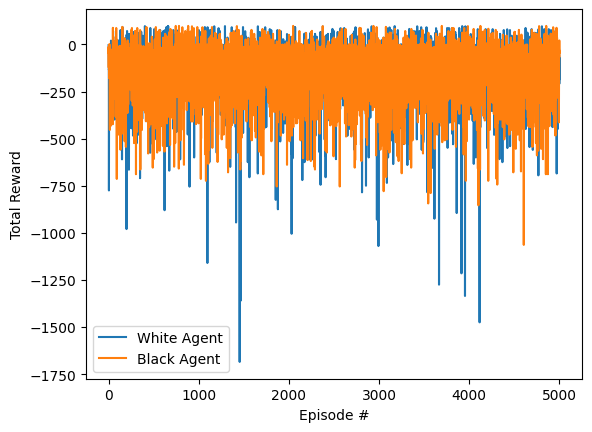

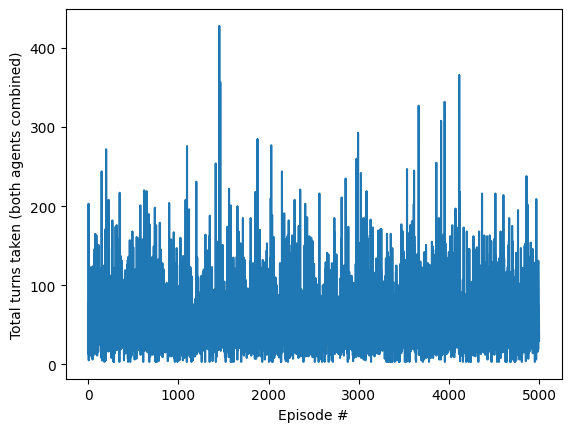

In [21]:
do_deepq_plots(True)

Its kinda hard to see if we are improving or not, since its two deepq algorithms fighting against eachother. We would hope that through their trials and tribulations the networks are improving, so lets pit them against previous versions of themselves. If they really got better, they should be able to defeat the previous versions of their opponents with less experience

500
500
Game # 0
Game # 1
Game # 2
Game # 3
Game # 4
Game # 5
Game # 6
Game # 7
Game # 8
Game # 9
Game # 10
Game # 11
Game # 12
Game # 13
Game # 14
Game # 15
Game # 16
Game # 17
Game # 18
Game # 19
Game # 20
Game # 21
Game # 22
Game # 23
Game # 24


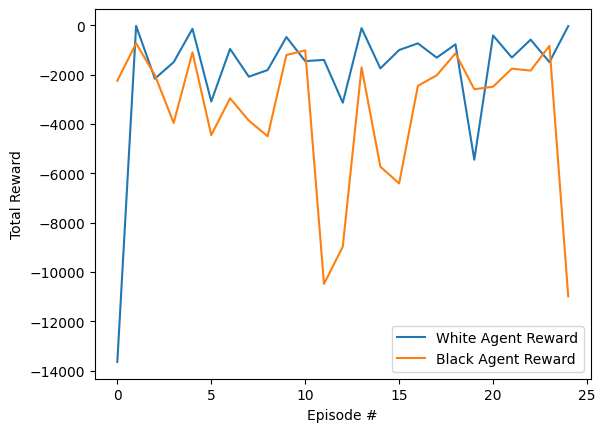

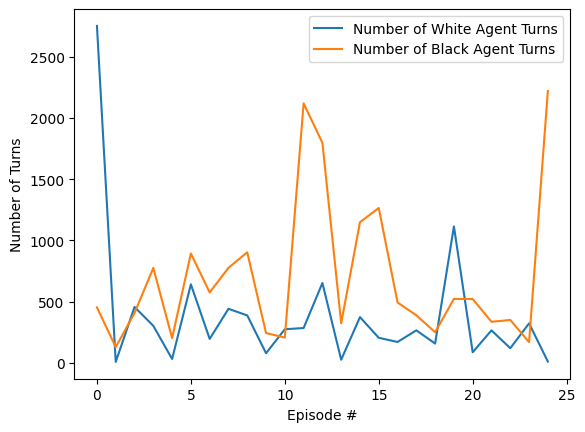

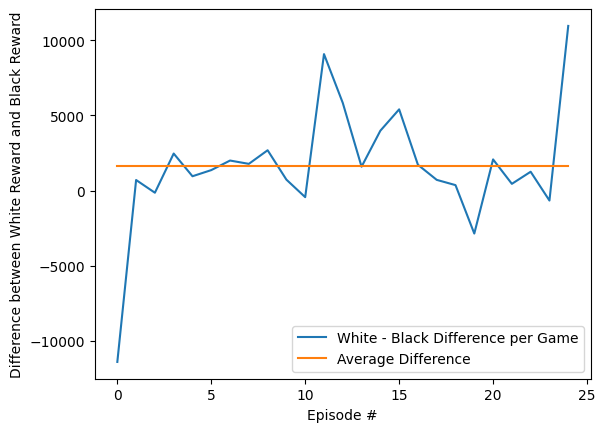

Game # 0
Game # 1
Game # 2
Game # 3
Game # 4
Game # 5
Game # 6
Game # 7
Game # 8
Game # 9
Game # 10
Game # 11
Game # 12
Game # 13
Game # 14
Game # 15
Game # 16
Game # 17
Game # 18
Game # 19
Game # 20
Game # 21
Game # 22
Game # 23
Game # 24


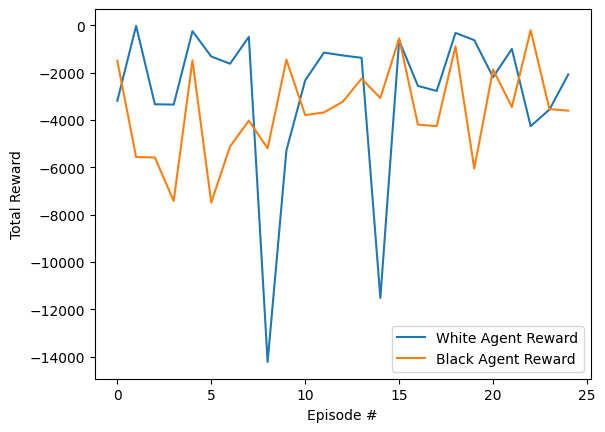

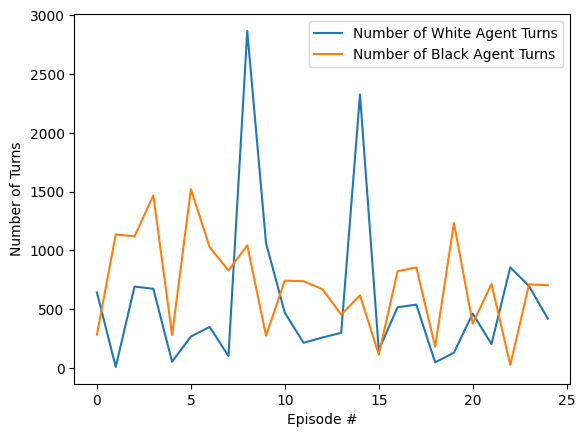

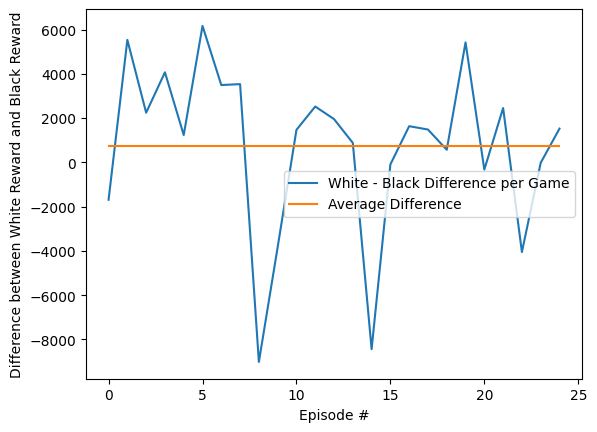

In [22]:
print(len(previous_black_nn_list))
print(len(previous_white_nn_list))

# Set the epsilon to (near) 0
EPSILON = 0.01

# Play a game against a previous iteration of an agent, dont do any improvement or anything
def play_game_against_previous(white_player, black_player, n_games):
    white_player_reward_per_game = []
    black_player_reward_per_game = []
    # Track how many turns each agent takes per game
    #   These might be different because an "invalid move" still counts as a move, even though it wont pass the turn
    white_turns_per_game = []
    black_turns_per_game = []
    for game in range(n_games):
        print("Game #", game)
        # Prepare the environment
        goEnv.env_cleanup()
        goEnv.env_start()
        white_player_reward_per_game.append(0)
        black_player_reward_per_game.append(0)
        white_turns_per_game.append(0)
        black_turns_per_game.append(0)
        while (goEnv.who_won == 0): # While the game is still going, and nobody won
                current_agent = white_player
                if (goEnv.turn == 1):
                    # It is black's turn to play
                    current_agent = black_player

                # select our action
                action = select_action(current_agent, goEnv.get_board_tensor())

                # Act on this action
                this_x, this_y = goEnv.action_int_to_xy(action)
                reward_state_term = goEnv.env_step(this_x, this_y, goEnv.turn)
                
                reward = reward_state_term[0]

                # Update our data for the plots
                if (goEnv.last_turn == 1):
                    # It WAS black's turn when we got the rewards
                    black_player_reward_per_game[game] += reward
                    black_turns_per_game[game] += 1
                if (goEnv.last_turn == 0):
                    # It WAS white's turn
                    white_player_reward_per_game[game] += reward
                    white_turns_per_game[game] += 1
    # Display our graph
    plt.figure(3)
    
    plt.xlabel("Episode #")
    plt.ylabel("Total Reward")
    plt.plot(white_player_reward_per_game, label = "White Agent Reward")
    plt.plot(black_player_reward_per_game, label = "Black Agent Reward")
    plt.legend()
    plt.show()

    plt.figure(4)
    plt.xlabel("Episode #")
    plt.ylabel("Number of Turns")
    plt.plot(white_turns_per_game, label = "Number of White Agent Turns")
    plt.plot(black_turns_per_game, label = "Number of Black Agent Turns")
    plt.legend()
    plt.show()

    plt.figure(5)
    plt.xlabel("Episode #")
    plt.ylabel("Difference between White Reward and Black Reward")

    white_vs_black_difference_per_game = []
    for i in range(n_games):
        difference = white_player_reward_per_game[i] - black_player_reward_per_game[i]
        white_vs_black_difference_per_game.append(difference)
    plt.plot(white_vs_black_difference_per_game, label = "White - Black Difference per Game")
    average_difference = np.average(white_vs_black_difference_per_game)
    # Hacky way to do this buttttt
    average_difference = np.linspace(start=average_difference, stop=average_difference, num=n_games)
    plt.plot(average_difference, label = "Average Difference")
    plt.legend()
    plt.show()

play_game_against_previous(white_agent, previous_black_nn_list[0], 25)
play_game_against_previous(previous_white_nn_list[0], black_agent, 25)


Have the agents play against a random player, hopefully they should destroy this one

In [23]:
# Play a game against a previous iteration of an agent, dont do any improvement or anything
# Returns the average difference of white_reward - random_agent_reward
def white_play_game_against_random(white_player_agent, n_games, show_graph, show_board):
    white_player_reward_per_game = []
    random_player_reward_per_game = []
    # Track how many turns each agent takes per game
    #   These might be different because an "invalid move" still counts as a move, even though it wont pass the turn
    white_turns_per_game = []
    random_turns_per_game = []
    for game in range(n_games):
        print("Game #", game)
        # Prepare the environment
        goEnv.env_cleanup()
        goEnv.env_start()
        white_player_reward_per_game.append(0)
        random_player_reward_per_game.append(0)
        white_turns_per_game.append(0)
        random_turns_per_game.append(0)
        while (goEnv.who_won == 0): # While the game is still going, and nobody won
                if (goEnv.turn == 0):
                    # It is white's turn
                    # select our action
                    action = select_action(white_agent, goEnv.get_board_tensor())
                else:
                    # It is the random players turn
                    action = random.randrange(0, goEnv.go_board_size())

                # Act on this action
                this_x, this_y = goEnv.action_int_to_xy(action)
                reward_state_term = goEnv.env_step(this_x, this_y, goEnv.turn)

                if (show_board == True):
                    print("\n ======= \n")
                    print("Action taken:", "X:", this_x, "| Y:", this_y)
                    goEnv.print_go_board()
                    print("\n ======= \n")
                
                reward = reward_state_term[0]

                # Update our data for the plots
                if (goEnv.last_turn == 1):
                    # It WAS black's turn when we got the rewards
                    random_player_reward_per_game[game] += reward
                    random_turns_per_game[game] += 1
                if (goEnv.last_turn == 0):
                    # It WAS white's turn
                    white_player_reward_per_game[game] += reward
                    white_turns_per_game[game] += 1

    # Calculate the average difference
    white_vs_black_difference_per_game = []
    for i in range(n_games):
        difference = white_player_reward_per_game[i] - random_player_reward_per_game[i]
        white_vs_black_difference_per_game.append(difference)
    average_difference_val = np.average(white_vs_black_difference_per_game)
    # Hacky way to do this buttttt
    average_difference = np.linspace(start=average_difference_val, stop=average_difference_val, num=n_games)

    if (show_graph == False):
        # Dont show the graphs
        return average_difference_val
    
    # Display our graph
    plt.figure(6)
    plt.xlabel("Episode #")
    plt.ylabel("Total Reward")
    plt.plot(white_player_reward_per_game, label = "White Agent Reward")
    plt.plot(random_player_reward_per_game, label = "Random Agent Reward")
    plt.legend()
    plt.show()

    plt.figure(7)
    plt.xlabel("Episode #")
    plt.ylabel("Number of Turns")
    plt.plot(white_turns_per_game, label = "Number of White Agent Turns")
    plt.plot(random_turns_per_game, label = "Number of Random Agent Turns")
    plt.legend()
    plt.show()


    plt.figure(8)
    plt.xlabel("Episode #")
    plt.ylabel("Difference between White Reward and Black Reward")
    plt.plot(white_vs_black_difference_per_game, label = "White - Black Difference per Game")
    plt.plot(average_difference, label = "Average Difference")
    plt.legend()

    plt.show()

    return average_difference_val

Game # 0
Game # 1
Game # 2
Game # 3
Game # 4
Game # 5
Game # 6
Game # 7
Game # 8
Game # 9


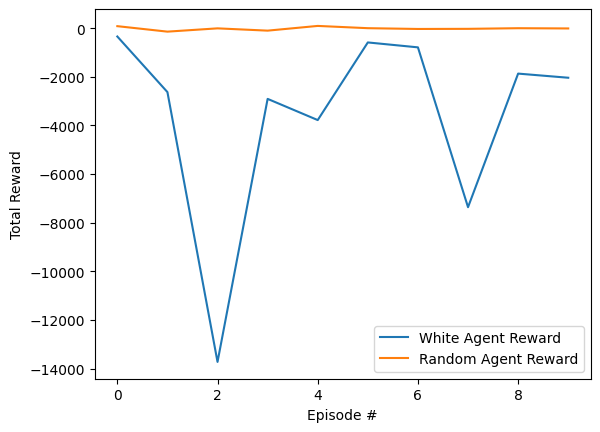

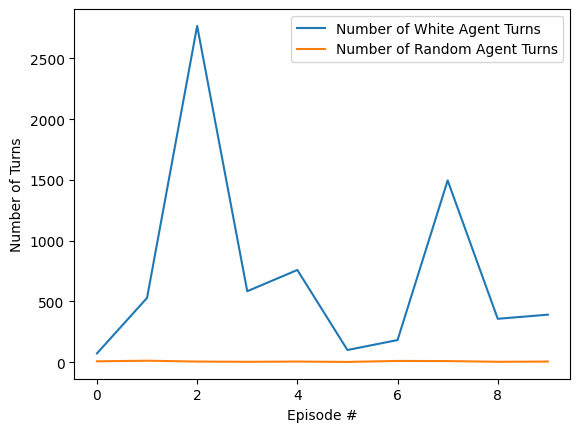

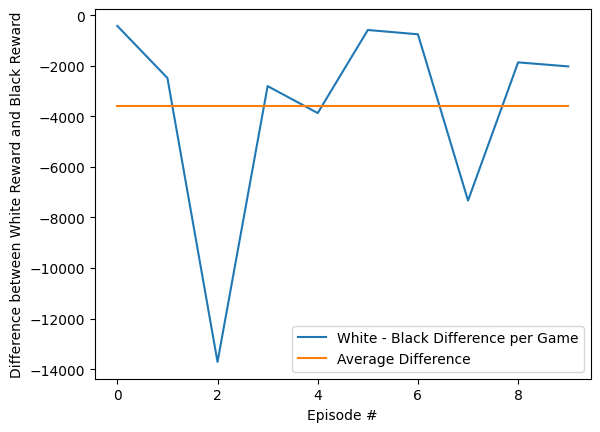

np.float64(-3586.1)

In [24]:
white_play_game_against_random(white_agent, 10, True, False)

Test all the previous versions against a random agent and compare their results, to see if we are improving with iteration

White History Agents: 500
White History Agent # 0 Now Playing...
Game # 0
Game # 1
Game # 2
Game # 3
Game # 4
Game # 5
Game # 6
Game # 7
Game # 8
Game # 9
White History Agent # 1 Now Playing...
Game # 0
Game # 1
Game # 2
Game # 3
Game # 4
Game # 5
Game # 6
Game # 7
Game # 8
Game # 9
White History Agent # 2 Now Playing...
Game # 0
Game # 1
Game # 2
Game # 3
Game # 4
Game # 5
Game # 6
Game # 7
Game # 8
Game # 9
White History Agent # 3 Now Playing...
Game # 0
Game # 1
Game # 2
Game # 3
Game # 4
Game # 5
Game # 6
Game # 7
Game # 8
Game # 9
White History Agent # 4 Now Playing...
Game # 0
Game # 1
Game # 2
Game # 3
Game # 4
Game # 5
Game # 6
Game # 7
Game # 8
Game # 9
White History Agent # 5 Now Playing...
Game # 0
Game # 1
Game # 2
Game # 3
Game # 4
Game # 5
Game # 6
Game # 7
Game # 8
Game # 9
White History Agent # 6 Now Playing...
Game # 0
Game # 1
Game # 2
Game # 3
Game # 4
Game # 5
Game # 6
Game # 7
Game # 8
Game # 9
White History Agent # 7 Now Playing...
Game # 0
Game # 1
Game # 2
Game 

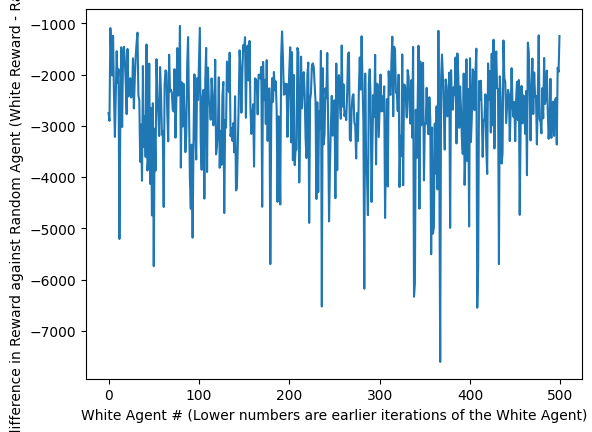

In [25]:
NUM_GAMES_PER = 10
history_average_difference_list = []
print("White History Agents:", len(previous_white_nn_list))
i = 0
for white_history_agent in previous_white_nn_list:
    print("White History Agent #", i, "Now Playing...")
    history_average_difference_list.append(white_play_game_against_random(white_history_agent, NUM_GAMES_PER, False, False))
    i += 1

plt.xlabel("White Agent # (Lower numbers are earlier iterations of the White Agent)")
plt.ylabel("Average difference in Reward against Random Agent (White Reward - Random Reward)")
plt.plot(history_average_difference_list)
plt.show()

This is a little hard to see, and maybe my copy function is broken.... Lets see an animation of our white agent playing against a black random agent

In [26]:
white_play_game_against_random(white_agent, 1, False, True)

Game # 0


Action taken: X: tensor([[0]]) | Y: tensor([[2]])
..w
...
...




Action taken: X: 1 | Y: 0
..w
b..
...




Action taken: X: tensor([[1]]) | Y: tensor([[1]])
..w
bw.
...




Action taken: X: 2 | Y: 2
..w
bw.
..b




Action taken: X: tensor([[1]]) | Y: tensor([[2]])
..w
bww
..b




Action taken: X: 0 | Y: 1
.bw
bww
..b




Action taken: X: tensor([[1]]) | Y: tensor([[2]])
.bw
bww
..b




Action taken: X: tensor([[1]]) | Y: tensor([[2]])
.bw
bww
..b




Action taken: X: tensor([[1]]) | Y: tensor([[2]])
.bw
bww
..b




Action taken: X: tensor([[1]]) | Y: tensor([[2]])
.bw
bww
..b




Action taken: X: tensor([[1]]) | Y: tensor([[2]])
.bw
bww
..b




Action taken: X: tensor([[1]]) | Y: tensor([[2]])
.bw
bww
..b




Action taken: X: tensor([[1]]) | Y: tensor([[2]])
.bw
bww
..b




Action taken: X: tensor([[1]]) | Y: tensor([[2]])
.bw
bww
..b




Action taken: X: tensor([[1]]) | Y: tensor([[2]])
.bw
bww
..b




Action taken: X: tensor([[1]]) | Y: tensor([[2]])
.bw
bww
..b




Actio

np.float64(-2181.0)